# RAIL Prior

In [1]:
import numpy as np
from numpy.linalg import cholesky
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.stats as stats
import qp

import nz_prior as nzp

## Load Data

In [2]:
dummy = np.load('../tests/dummy.npz')
zs = dummy['zs']
nzs = dummy['pzs']
dz = np.mean(np.diff(zs))
zs_edges = np.append(zs - dz/2, zs[-1] + dz/2)
q = qp.Ensemble(qp.hist, data={"bins":zs_edges, "pdfs":nzs})

In [3]:
base = nzp.PriorBase(q)

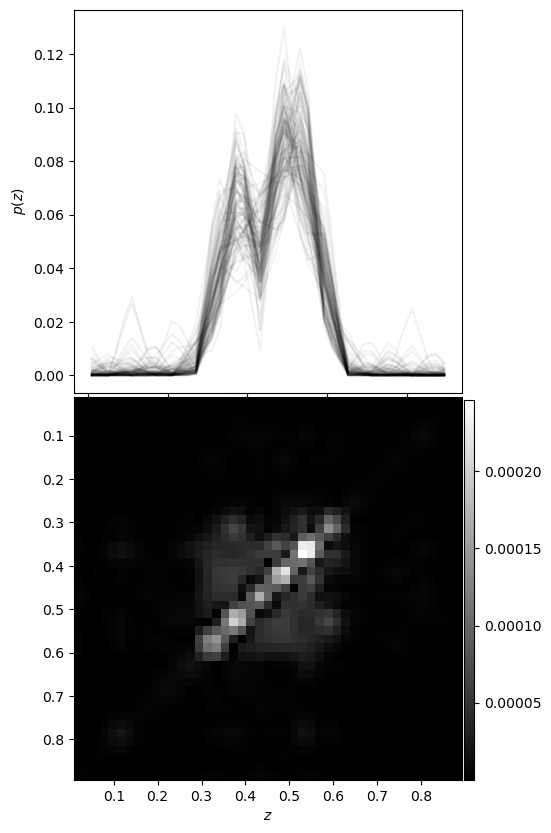

In [4]:
figure, axis = plt.subplots(2, 1, figsize=(5,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
for i in range(100):
    axis[0].plot(base.z, base.nzs[i], 'k-', alpha=0.05)
axis[0].set_ylabel(r'$p(z)$')
im = axis[1].imshow(abs(base.nz_cov), aspect='auto',
                    origin='lower', cmap='gray',
                    extent=[min(zs), max(zs), max(zs), min(zs)])
axis[1].set_xlabel(r'$z$')
cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
figure.colorbar(im, cax=cbar_ax)
plt.show()

# Shifts

In [5]:
shifts = nzp.PriorShifts(q)

In [6]:
pz_fid = [shifts.z, shifts.nz_mean]

In [7]:
shifted_nzs = np.array([nzp.shift_model(pz_fid, shifts.sample_prior()["delta_z"])[1] for i in range(100)])

In [8]:
shifted_cov = np.cov(shifted_nzs.T)
shifted_mean = np.mean(shifted_nzs, axis=0)

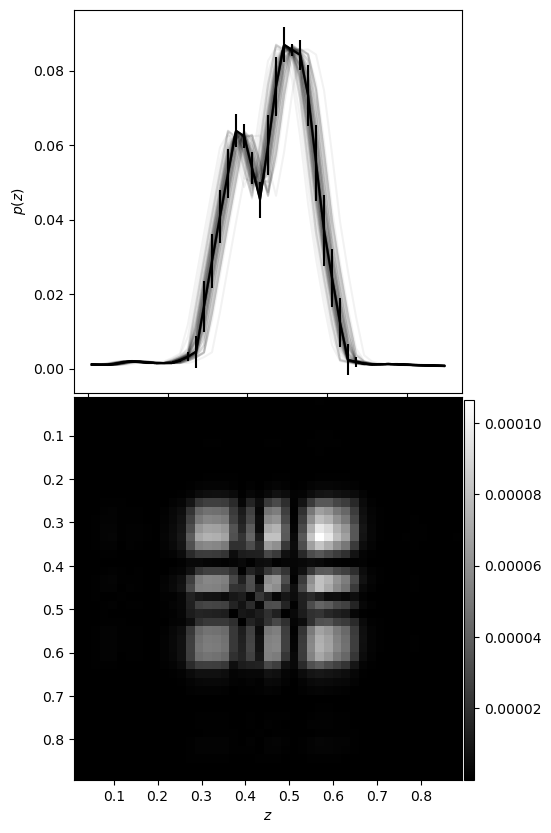

In [9]:
figure, axis = plt.subplots(2, 1, figsize=(5,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
for i in range(100):
    pz = shifted_nzs[i]
    axis[0].plot(shifts.z, pz, 'k-', alpha=0.05)
axis[0].errorbar(shifts.z, shifts.nz_mean, yerr=np.sqrt(np.diag(shifted_cov)), fmt='k-')
axis[0].set_ylabel(r'$p(z)$')
im = axis[1].imshow(abs(shifted_cov), aspect='auto',
                    origin='lower', cmap='gray',
                    extent=[min(zs), max(zs), max(zs), min(zs)])
axis[1].set_xlabel(r'$z$')
cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
figure.colorbar(im, cax=cbar_ax)
#plt.savefig('docs/source/assets/shifts.png')
plt.show()

In [10]:
D_shifts = nzp.Sym_Dkl(shifted_mean, shifted_cov, base.nz_mean, base.nz_cov)


The covariance matrix will be regularized
The covariance matrix will be diagonalized
The covariance matrix will be regularized
The covariance matrix will be diagonalized


# Shifts & Widths

In [11]:
SnW = nzp.PriorShiftsWidths(q)

In [12]:
SnW_nzs = []
for i in range(100):
    prior_sample = SnW.sample_prior()
    shift = prior_sample["delta_z"]
    width = prior_sample["width_z"]
    pz = nzp.shift_and_width_model(pz_fid, [shift, width])[1]
    SnW_nzs.append(pz)
SnW_nzs = np.array(SnW_nzs)

In [13]:
SnW_cov = np.cov(SnW_nzs.T)
SnW_mean = np.mean(SnW_nzs, axis=0)

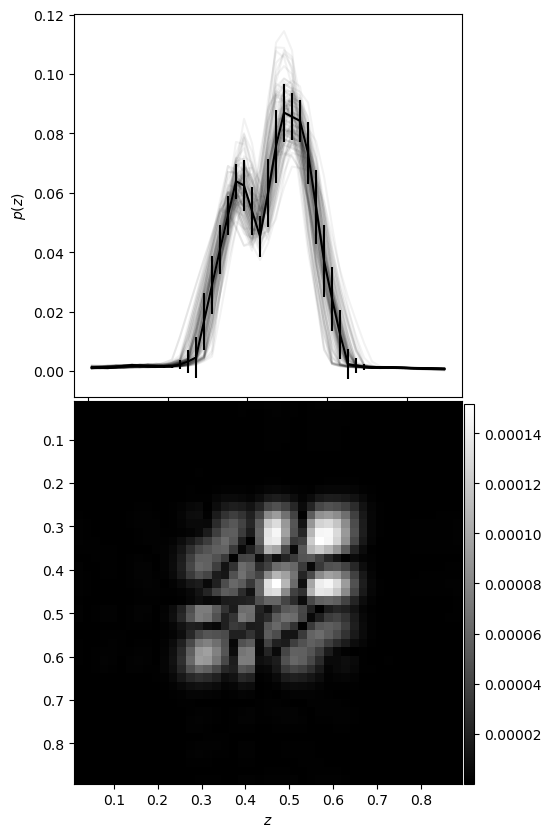

In [14]:
figure, axis = plt.subplots(2, 1, figsize=(5,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
for i in range(100):
    axis[0].plot(SnW.z, SnW_nzs[i], 'k-', alpha=0.05)
axis[0].errorbar(SnW.z, SnW.nz_mean, yerr=np.sqrt(np.diag(SnW_cov)), fmt='k-')
axis[0].set_ylabel(r'$p(z)$')
im = axis[1].imshow(abs(SnW_cov), aspect='auto',
                    origin='lower', cmap='gray',
                    extent=[min(zs), max(zs), max(zs), min(zs)])
axis[1].set_xlabel(r'$z$')
cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
figure.colorbar(im, cax=cbar_ax)
#plt.savefig('docs/source/assets/gp.png')
plt.show()

In [15]:
D_SnW = nzp.Sym_Dkl(SnW_mean, SnW_cov, base.nz_mean, base.nz_cov)


The covariance matrix will be regularized
The covariance matrix will be regularized
The covariance matrix will be diagonalized


/home/jaimerz/anaconda3/envs/qp_dev/lib/python3.12/site-packages/nz_prior/utils.py:39: RuntimeWarning: divide by zero encountered in scalar divide
  T3 = np.log(K_2_det / K_1_det)
/home/jaimerz/anaconda3/envs/qp_dev/lib/python3.12/site-packages/nz_prior/utils.py:39: RuntimeWarning: divide by zero encountered in log
  T3 = np.log(K_2_det / K_1_det)
/home/jaimerz/anaconda3/envs/qp_dev/lib/python3.12/site-packages/nz_prior/utils.py:48: RuntimeWarning: invalid value encountered in scalar add
  return 0.5 * (Dkl_12 + Dkl_21)


# GP

In [16]:
gp = nzp.PriorGP(q)

In [17]:
gp_nzs = np.array([list(gp.sample_prior().values()) for i in range(100)])

The covariance matrix will be regularized
The covariance matrix will be diagonalized


In [18]:
gp_cov = np.cov(gp_nzs.T)
gp_mean = np.mean(gp_nzs, axis=0)

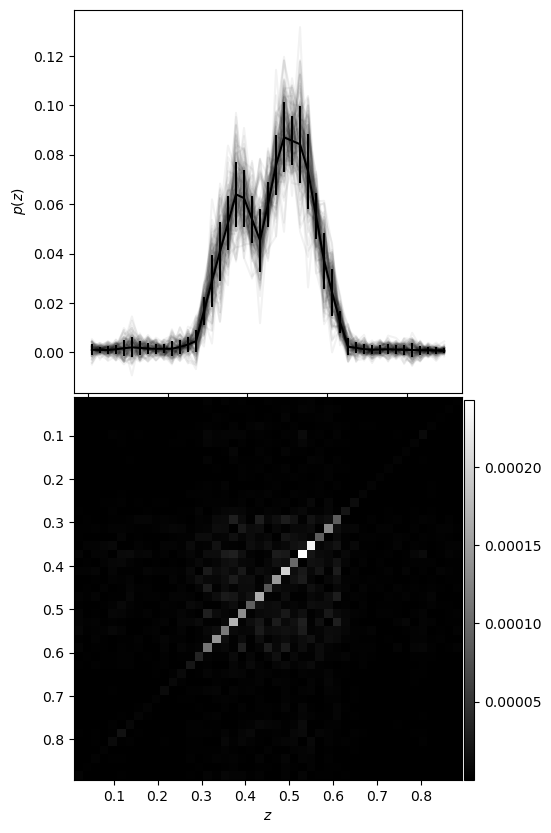

In [19]:
figure, axis = plt.subplots(2, 1, figsize=(5,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
for i in range(100):
    axis[0].plot(gp.z, gp_nzs[i], 'k-', alpha=0.05)
axis[0].errorbar(gp.z, gp.nz_mean, yerr=np.sqrt(np.diag(gp_cov)), fmt='k-')
axis[0].set_ylabel(r'$p(z)$')
im = axis[1].imshow(abs(gp_cov), aspect='auto',
                    origin='lower', cmap='gray',
                    extent=[min(zs), max(zs), max(zs), min(zs)])
axis[1].set_xlabel(r'$z$')
cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
figure.colorbar(im, cax=cbar_ax)
#plt.savefig('docs/source/assets/gp.png')
plt.show()

In [20]:
D_gp = nzp.Sym_Dkl(base.nz_mean, base.nz_cov, gp_mean, gp_cov)


The covariance matrix will be regularized
The covariance matrix will be diagonalized


# Comb

In [21]:
M = 10
comb = nzp.PriorComb(q, ncombs=M)

In [22]:
comb_nzs = []
for i in range(100):
    prior_sample = comb.sample_prior()
    W = np.array([prior_sample[name] for name in comb._get_params_names()])
    pz = nzp.comb_model(pz_fid, W)[1]
    comb_nzs.append(pz)
comb_nzs = np.array(comb_nzs)

The covariance matrix will be regularized


In [23]:
comb_cov = np.cov(comb_nzs.T)
comb_mean = np.mean(comb_nzs, axis=0)

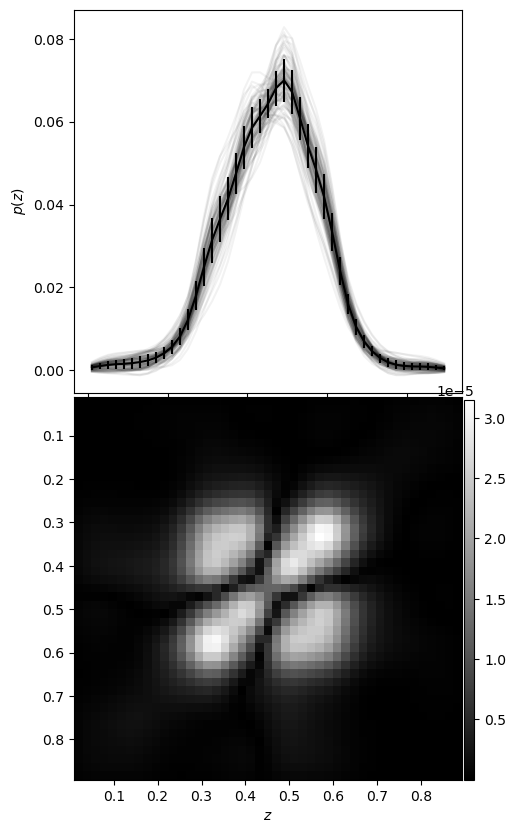

In [24]:
figure, axis = plt.subplots(2, 1, figsize=(5,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
for i in range(100):
    axis[0].plot(comb.z, comb_nzs[i], 'k-', alpha=0.05)
axis[0].errorbar(comb.z, np.mean(comb_nzs, axis=0),
                 yerr=np.sqrt(np.diag(comb_cov)),
                 fmt='k-')
axis[0].set_ylabel(r'$p(z)$')
im = axis[1].imshow(abs(comb_cov), aspect='auto',
                    origin='lower', cmap='gray',
                    extent=[min(zs), max(zs), max(zs), min(zs)])
axis[1].set_xlabel(r'$z$')
cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
figure.colorbar(im, cax=cbar_ax)
#plt.savefig('docs/source/assets/gp.png')
plt.show()

In [25]:
D_comb = nzp.Sym_Dkl(comb_mean, comb_cov, base.nz_mean, base.nz_cov)

The covariance matrix will be regularized
The covariance matrix will be diagonalized
The covariance matrix will be regularized
The covariance matrix will be diagonalized


# PCA

In [26]:
M = 5
PCA = nzp.PriorPCA(q, npca=M)

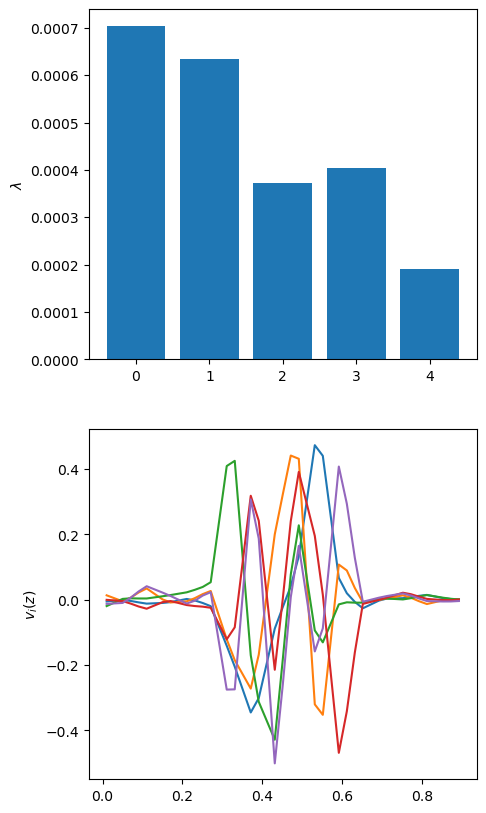

In [27]:
figure, axis = plt.subplots(2, 1, figsize=(5,10))
axis[0].bar(range(len(PCA.eigvals)), PCA.eigvals)
axis[0].set_ylabel(r'$\lambda$')

axis[1].plot(PCA.z, PCA.eigvecs.T)
axis[1].set_ylabel(r'$v_i(z)$')
plt.show()

In [28]:
pca_nzs = []
nz_fid = [PCA.z, PCA.nz_mean]
for i in range(100):
    prior_sample = PCA.sample_prior()
    W = np.array([prior_sample[name] for name in PCA._get_params_names()])
    pz = nzp.pca_model(nz_fid, W, PCA.eigvecs)[1]
    pca_nzs.append(pz)
pca_nzs = np.array(pca_nzs)

In [29]:
pca_cov = np.cov(pca_nzs.T)
pca_mean = np.mean(pca_nzs, axis=0)

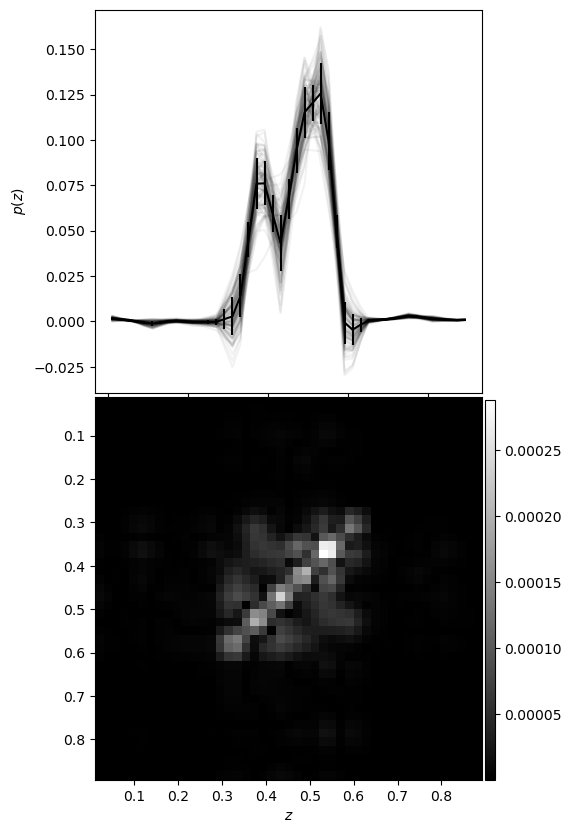

In [30]:
figure, axis = plt.subplots(2, 1, figsize=(5,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
for i in range(100):
    axis[0].plot(PCA.z, pca_nzs[i], 'k-', alpha=0.05)
axis[0].errorbar(PCA.z, np.mean(pca_nzs, axis=0),
                 yerr=np.sqrt(np.diag(pca_cov)),
                 fmt='k-')
axis[0].set_ylabel(r'$p(z)$')
im = axis[1].imshow(abs(pca_cov), aspect='auto',
                    origin='lower', cmap='gray',
                    extent=[min(zs), max(zs), max(zs), min(zs)])
axis[1].set_xlabel(r'$z$')
cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
figure.colorbar(im, cax=cbar_ax)
#plt.savefig('docs/source/assets/gp.png')
plt.show()

In [31]:
D_PCA = nzp.Sym_Dkl(pca_mean, pca_cov, base.nz_mean, base.nz_cov)

The covariance matrix will be regularized
The covariance matrix will be diagonalized
The covariance matrix will be regularized
The covariance matrix will be diagonalized


# Comparison


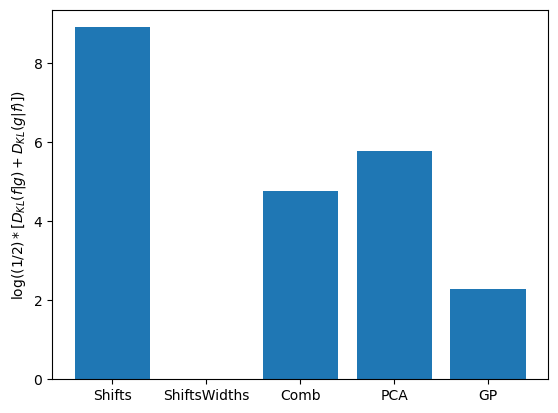

In [32]:
plt.bar(np.arange(5), np.log(np.array([D_shifts, D_SnW, D_comb, D_PCA, D_gp])))
plt.xticks(np.arange(5), ['Shifts', 'ShiftsWidths', 'Comb', 'PCA', 'GP'])
plt.ylabel(r'$\log ((1/2)*[D_{KL}(f|g)+D_{KL}(g|f)])$')
plt.show()